<a href="https://colab.research.google.com/github/krishikasahni/Deep-Learning/blob/main/Deep_Learning_Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

data_path = "/kaggle/input/datasets/krishikasahni/spatxt/spa.txt"
lines = open(data_path, encoding="utf-8").read().split("\n")[:20000]

input_texts = []
target_texts = []

for line in lines:
    if "\t" in line:
        eng, spa = line.split("\t")[:2]
        input_texts.append(eng)
        target_texts.append("\t " + spa + " \n")

num_words = 5000

input_tok = Tokenizer(num_words=num_words, filters='')
input_tok.fit_on_texts(input_texts)
input_seq = input_tok.texts_to_sequences(input_texts)

target_tok = Tokenizer(num_words=num_words, filters='')
target_tok.fit_on_texts(target_texts)
target_seq = target_tok.texts_to_sequences(target_texts)

max_enc = max(len(s) for s in input_seq)
max_dec = max(len(s) for s in target_seq)

encoder_input = pad_sequences(input_seq, maxlen=max_enc, padding='post')
decoder_input = pad_sequences(target_seq, maxlen=max_dec, padding='post')

decoder_target = np.zeros_like(decoder_input)
decoder_target[:, :-1] = decoder_input[:, 1:]

latent_dim = 128

enc_inputs = Input(shape=(None,))
enc_emb = Embedding(num_words, latent_dim)(enc_inputs)
_, state_h, state_c = LSTM(latent_dim, return_state=True)(enc_emb)
enc_states = [state_h, state_c]

dec_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_words, latent_dim)
dec_emb = dec_emb_layer(dec_inputs)

dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, _, _ = dec_lstm(dec_emb, initial_state=enc_states)
dec_dense = Dense(num_words, activation='softmax')
dec_outputs = dec_dense(dec_outputs)

model = Model([enc_inputs, dec_inputs], dec_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(
    [encoder_input, decoder_input],
    np.expand_dims(decoder_target, -1),
    batch_size=128,
    epochs=5,
    validation_split=0.2
)

encoder_model = Model(enc_inputs, enc_states)

dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_states_inputs = [dec_state_input_h, dec_state_input_c]

dec_emb2 = dec_emb_layer(dec_inputs)
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_emb2, initial_state=dec_states_inputs)
dec_states2 = [state_h2, state_c2]
dec_outputs2 = dec_dense(dec_outputs2)

decoder_model = Model(
    [dec_inputs] + dec_states_inputs,
    [dec_outputs2] + dec_states2
)

def translate_sentence(sentence):
    seq = input_tok.texts_to_sequences([sentence])
    seq = pad_sequences(seq, maxlen=max_enc, padding='post')

    states = encoder_model.predict(seq, verbose=0)

    target_seq = np.zeros((1,1))
    target_seq[0,0] = target_tok.word_index['\t']

    decoded_sentence = ''
    while True:
        output_tokens, h, c = decoder_model.predict([target_seq] + states, verbose=0)
        idx = np.argmax(output_tokens[0, -1, :])
        word = target_tok.index_word.get(idx, '')

        if word == '\n' or len(decoded_sentence.split()) > 20:
            break

        decoded_sentence += ' ' + word
        target_seq[0,0] = idx
        states = [h, c]

    return decoded_sentence.strip()

while True:
    user_input = input("\nEnter English sentence (or type 'exit'): ")
    if user_input.lower() == "exit":
        break
    print("Spanish:", translate_sentence(user_input))

2026-02-20 14:47:24.704897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771598844.917344      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771598844.966362      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771598845.439392      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771598845.439458      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771598845.439463      55 computation_placer.cc:177] computation placer alr

Epoch 1/5


I0000 00:00:1771598876.774741     124 cuda_dnn.cc:529] Loaded cuDNN version 91002


125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.6722 - loss: 4.5482 - val_accuracy: 0.6636 - val_loss: 2.0704
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7652 - loss: 1.6576 - val_accuracy: 0.7287 - val_loss: 1.8954
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7824 - loss: 1.5289 - val_accuracy: 0.7361 - val_loss: 1.8187
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7871 - loss: 1.4474 - val_accuracy: 0.7409 - val_loss: 1.7606
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7900 - loss: 1.3911 - val_accuracy: 0.7435 - val_loss: 1.7113



Enter English sentence (or type 'exit'):  How are you?


Spanish: yo lo



Enter English sentence (or type 'exit'):  I am fine


Spanish: tom es



Enter English sentence (or type 'exit'):  exit


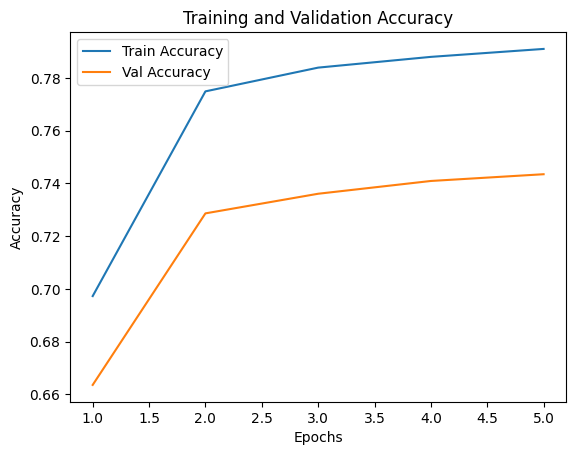

In [ ]:
import matplotlib.pyplot as plt
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot Accuracy
plt.figure()
plt.plot(epochs, accuracy)
plt.plot(epochs, val_accuracy)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy", "Val Accuracy"])
plt.show()